# Import Dependencies & Data

In [3]:
import numpy as np 
import pandas as pd 
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import random
import copy
from sklearn.model_selection import train_test_split
import os

In [2]:
# Have to tranpose and get it images in shape [num_images, H, W, num_channels]
x_train = np.load('/kaggle/input/cifar10-comp/train_images.npy')
y_train = pd.read_csv('/kaggle/input/cifar10-comp/train_labels.csv')
test = np.load('/kaggle/input/cifar10-comp/test_images.npy')

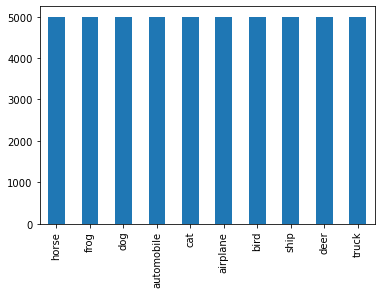

In [3]:
y_train['Category'].value_counts().plot(kind='bar')

The target variable is a discrete random variable with a cardinality of 10, with every class having an equal number of examples in it. So this is a multi-class classification problem with 10 categories with no class imbalance at all

In [4]:
# Visualize some images 
def img_visualizer(imgs, labels, nrows, ncols, random_state =1):
    np.random.seed(seed = random_state)
    fig, ax = plt.subplots(nrows, ncols, figsize = (15,8))
    plt.setp(ax, xticks=[], yticks=[])
    for i in range(nrows):
        for j in range(ncols):
            random_num = np.random.randint(low = 0, high = imgs.shape[0])
            img_chosen = imgs.transpose(0,2,3,1)[random_num]
            ax[i,j].imshow(img_chosen)
            ax[i,j].set_title(labels.iloc[random_num]['Category'])
            plt.tight_layout() 

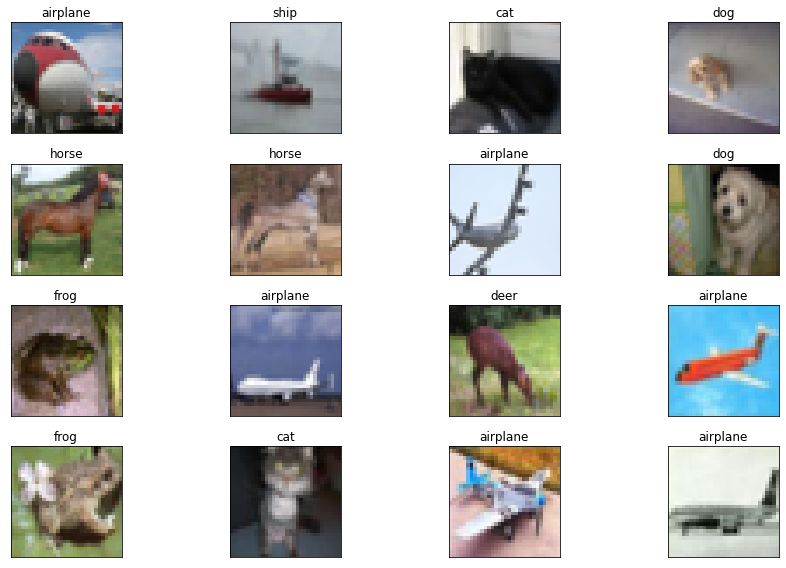

In [5]:
img_visualizer(x_train,y_train, 4, 4)

# Dataset Loading and Transformations

Transforms described in the paper include:
- Per pixel mean subtracted

Data augmentations:
- 4 pixels padded on each side
- 32x32 crop randomly taken from padded image or its horizontal flip 

Did the same data augmentations, but instead just normalized to a range between 0 and 1. 

In [400]:
class CIFAR_10_dataset(torch.utils.data.Dataset):
    def __init__(self, data_location, labels = None, transform = None):
        # has to be of shape batch, H, W, channels for transforms
        self.train = np.load(data_location).transpose(0,2,3,1)
        self.labels = labels
        if self.labels:
            self.y_train = pd.read_csv(labels)
            self.uniqueLabels = {cat:i for i,cat in enumerate(np.unique(self.y_train['Category']))}
            self.int_to_cat = {i:cat for i,cat in enumerate(np.unique(self.y_train['Category']))}
        self.transform = transform 
        
    def __len__(self):
        return self.train.shape[0]
    
    def __getitem__(self, idx):
        # Getting the ith feature vector + label (maybe) out of dataset 
        # cross entropy loss takes an integer in -> going to label encode the integers
        # going to be a tensor w/ 3 channels, 32W, 32H 
        ith_featureVector = self.train[idx]
        output_featureVector = self.transform(ith_featureVector)
        if self.labels:
            label = self.uniqueLabels[y_train.iloc[idx]['Category']]
            return output_featureVector, label 
        
        else:
            return output_featureVector

In [401]:
transforms = torchvision.transforms.Compose([
torchvision.transforms.ToPILImage(),
torchvision.transforms.Pad((4,4)),
torchvision.transforms.RandomHorizontalFlip(),
torchvision.transforms.RandomCrop((32,32)),
torchvision.transforms.ToTensor(),
# torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [402]:
trainSet = CIFAR_10_dataset('/kaggle/input/cifar10-comp/train_images.npy', '/kaggle/input/cifar10-comp/train_labels.csv', transform=transforms)

In [403]:
def visualize_postProcessedPics(dataset, nrows=4, ncols=4, seed =1):
    np.random.seed(seed)
    fig, ax = plt.subplots(nrows, ncols, figsize = (15,8))
    plt.setp(ax, xticks = [], yticks =[])
    for i in range(nrows):
        for j in range(ncols):
            random_pic = np.random.randint(0, len(dataset))
            # have to convert tensor to numpy and then transpose it to HxWxC to visualize 
            picture = dataset[random_pic][0].numpy().transpose(1,2,0)
            label = dataset.int_to_cat[dataset[random_pic][1]]
            ax[i,j].imshow(picture)
            ax[i,j].set_title(label)
            plt.tight_layout() 

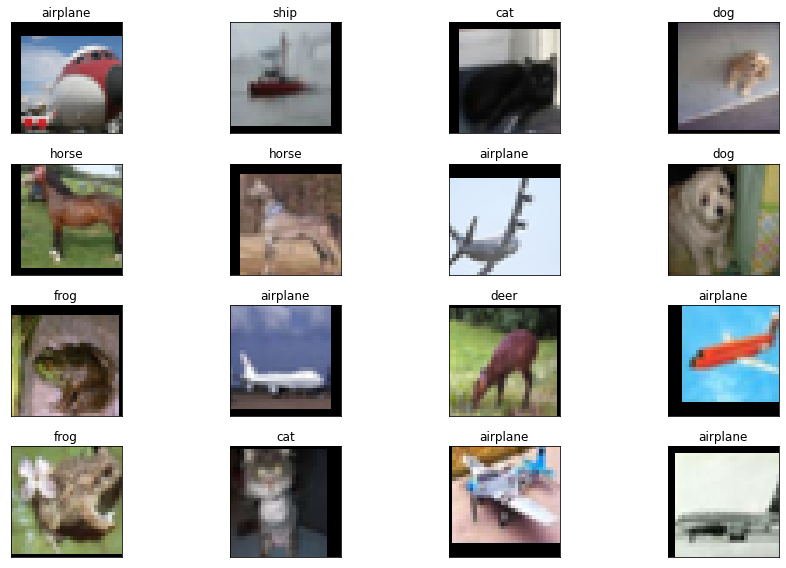

In [404]:
# post processed images look nearly identical to the 
visualize_postProcessedPics(trainSet)

Post processed images look nearly identical to the preprocessed images, other than the noticeable padding and crops on every single image.


# Defining Model Architecture

For CIFAR-10, the authors of the ResNet paper used a model architecture utilizing residual blocks with skip connections (with the idea being that these layers will be easily able to learn the identity function so at worst, shouldn't hurt accuracy, and at best can help the network learn interesting functions).

The authors used 6n stacks of these skip connections with different amount of filters (16, 32, 64 respectively from the first stack of skip connections), with a total network depth of 6n + 2.

Depth = 6n + 2 

So if you want a 20 layer network, this means n is:
20 = 6n +2 
18 = 6n
n = 3 -> We start off with a 3 x 3 x 3 x 16 conv2d operation, followed by 3 blocks of skip connection res blocks. We then downsample by a stride of 2 taking the images from 32x32 to 16x16, and upsample the number of filters from 16 to 32 and do 3 more blocks. The last set of blocks uses 64 filters, operating on an input size of 8x8 (being downsampled again by a stride of 2 when you start the third chunk of residual blocks).


In [405]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__() 
        self.out_channels = out_channels
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels))
        
        # initalize all the weights of every layer properly 
        self.model.apply(self._initWeights)
        
    def forward(self, x):
        return self.model(x) 
    
    def _initWeights(self, m):
        # init weights of convolution layers according to kaiming initialization
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode = 'fan_out',nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight,1)
            nn.init.constant_(m.bias, 0)

class ResidualBlocks(nn.Module):
    def __init__(self, num_layers_per_block):
        super(ResidualBlocks, self).__init__() 
        
        # create a module list to hold all the blocks 
        self.container = nn.ModuleList() 
        # need to store a couple projection shortcuts -> each block
        # excluding the first has one connection shortcut to connect the shortcut connection from prev
        # block to current block
        self.weighted_skip_connections = nn.ModuleDict()
        # 3 blocks of residual connections, each with a different amount of filters
        NumFilters = {0:16, 1:32, 2:64}
        weighted_skip_connectCounter = 0
        for i in range(3):
            # for every layer in the current residual block (we have 2n total layers in every block)
            for j in range(2*num_layers_per_block):
                in_channels = 16 if not self.container else self.container[-1].out_channels
    
                # we need a stride of two for the first convolution operation of the second batch of convolution operations
                # and for the third batch of convolution operations to downsample the input by 2 in terms of H and W
                stride = 2 if (i >0 and j==0) else 1
                # padding is kept at a constant value of 1 for every single conv operation, even when we're downsampling
                # keeps operations symmetric - we upsample the number of filters by a factor of 2 and downsample the H and W by
                # a factor of 2
                
                self.container.append(ConvBlock(in_channels, out_channels=NumFilters[i], kernel_size =3, stride = stride, padding = 1))
                
                if i >0 and j == 0:
                    self.weighted_skip_connections['WeightedSkipConnect'+str(weighted_skip_connectCounter)] = nn.Sequential(nn.Conv2d(in_channels = in_channels, out_channels = NumFilters[i], kernel_size=1, stride=2, padding=0),
                                                                     nn.BatchNorm2d(NumFilters[i]))
                    weighted_skip_connectCounter += 1 
                
    def forward(self, x):
        # This is where the actual skip connections happen
        # the architecture is technically the same as a plain deep net
        # but during the forward pass (and the backward pass too), we take 
        # the input to the even layers and fast forward it a count of 2 layers
        # down from the current layer 
        skip_connection = x.clone() 
        curr_x = x 
        weighted_skip_connectCounter = 0
        for i in range(len(self.container)): 
            # pass the current x through a conv operation and
            # batch norm operation 
            curr_x = self.container[i](curr_x)
            # every two steps, we add a skip connection to the curr_x and then pass it
            # through the ReLU 
            if i%2 == 1:
                # use a 1x1 convolution with a stride of 2 to downsample in terms of height and
                # width, and upsample in terms of number of channels ONLY if the shapes dont match 
                if skip_connection.shape != curr_x.shape:
                    skip_connection = self.weighted_skip_connections['WeightedSkipConnect'+str(weighted_skip_connectCounter)](skip_connection)
                    weighted_skip_connectCounter += 1 
                curr_x = curr_x.add(skip_connection)
                # curr_x becomes new skip connection 
                skip_connection = curr_x.clone() 
                
            # didnt include ReLU in the conv blocks because we add the
            # skip connection after the batch norm operation of the conv block, and then 
            # activate 
            curr_x = nn.ReLU()(curr_x)
        return curr_x

In [406]:
class ResNet(nn.Module):
    def __init__(self, depth = 20):
        torch.manual_seed(21)
        super(ResNet,self).__init__()
        n = (depth-2)//6
        assert type(n) is int, "Num blocks per stack not equal to integer"
        # This will return a nn.Module object with all of the residual skip blocks 
        # used in the network (total being 6*n of these blocks)
        residual_block_connections_6n = ResidualBlocks(n)
        # Then we just have a Conv2D operation, followed by the entire residual section block
        # followed by a global avg pool, then a 10 way softmax 
        self.model = nn.Sequential(
            ConvBlock(3, 16, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            residual_block_connections_6n,
            nn.AvgPool2d(kernel_size = 8),
            nn.Flatten(),
            # cross entropy loss expects raw logits of shape (N,C)
            nn.Linear(in_features = 64, out_features = 10))
        
    def forward(self, x):
        return self.model(x)
            

# Model Training

In [407]:
train_set, val_set = torch.utils.data.random_split(trainSet, (45000, 5000))
train_set.dataset = copy.deepcopy(train_set.dataset)
val_set.dataset = copy.deepcopy(val_set.dataset)
print(len(train_set))

45000


In [408]:
val_set.dataset.transform = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.ToTensor()])
val_set.dataset.transform

Compose(
    ToPILImage()
    ToTensor()
)

In [410]:
trainSet.transform

Compose(
    ToPILImage()
    Pad(padding=(4, 4), fill=0, padding_mode=constant)
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=None)
    ToTensor()
)

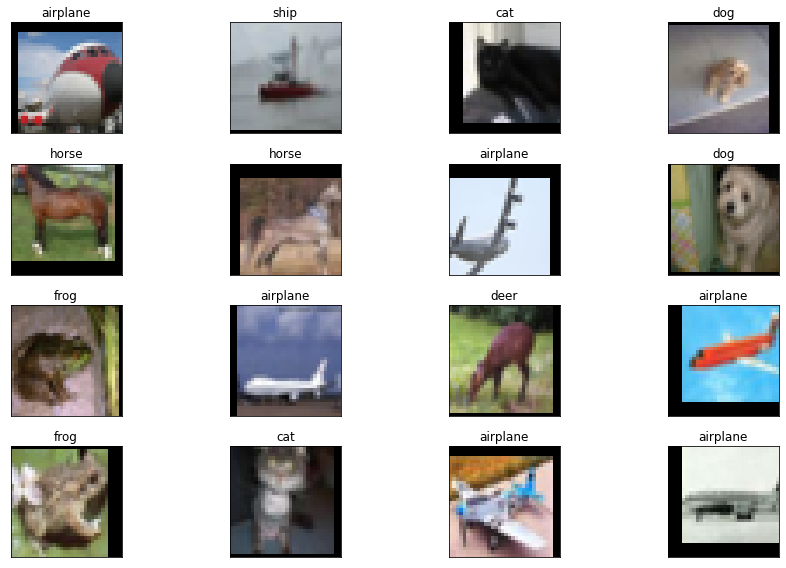

In [411]:
# Should expect to see cropped and rotated images
visualize_postProcessedPics(train_set.dataset)

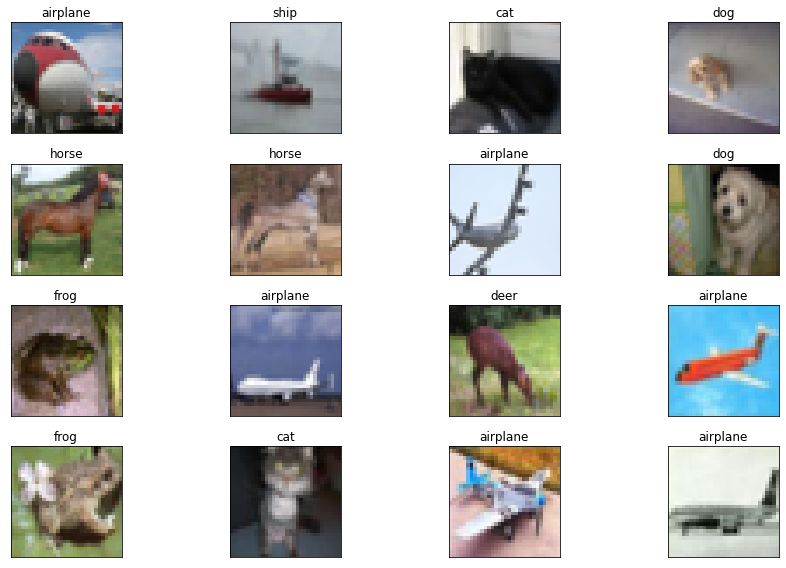

In [412]:
# Should expect to see normal images
visualize_postProcessedPics(val_set.dataset)

In [413]:
paramsVal = {'dataset':val_set, 'batch_size':5000, 'shuffle':True, 'num_workers':2}
val_loader = torch.utils.data.DataLoader(**paramsVal)

In [429]:
# Dataloader: Batches data, shuffles data, loads data in parallell -> way better than using a simple python 
# for loop to loop over our iterable dataset

# dont have the memory requirements to load in batches of size 128
paramsTrain = {'dataset':train_set, 'batch_size':64, 'shuffle':True, 'num_workers':2}
dataloader = torch.utils.data.DataLoader(**paramsTrain)

# By default, when we initialize a network it resides on the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 20 and 56 Layer Residual Networks 
ResidualNetwork_20Layers = ResNet(20)
ResidualNetwork_56Layers = ResNet(56)
ResidualNetwork_20Layers.to(device)
ResidualNetwork_56Layers.to(device)

# Loss Function - Cross Entropy Loss (multi class classification)
lossFunction = nn.CrossEntropyLoss()

# Optimizer to minimize the loss function SGD w/ momentum, with the loss function having an L2 regularization
# term with lambda = 0.0001
optimizer_20Layer = torch.optim.SGD(ResidualNetwork_20Layers.parameters(), lr=0.1, momentum=0.9, weight_decay= 0.0001)
optimizer_56Layer = torch.optim.SGD(ResidualNetwork_56Layers.parameters(), lr=0.1, momentum=0.9, weight_decay= 0.0001)

# Define a learning rate schedule - when our loss stops decreasing, we decrease the learning rate
# by a factor of 10
scheduler_20Layer = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_20Layer, 'min', factor =0.1,verbose = True)
scheduler_56Layer = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_56Layer, 'min', factor =0.1,verbose = True)

In [423]:
def train_network(deep_network, device, num_epochs, lossFunc, optimizer, scheduler, train_dataloader, val_loader):
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], [] 
    for epoch in range(num_epochs):
        # ensure model in training mode
        deep_network.train() 
        epoch_TrainLoss = []
        epoch_TrainAcc = [] 
        for batch_idx, (x, y) in enumerate(train_dataloader):
            # have to put the feature vectors and the labels on the same device that
            # the deep net resides on
            x = x.to(device)
            y = y.to(device)
            
            # we are doing mini-batch gradient descent, so we cannot accumulate gradients
            # between batches
            optimizer.zero_grad()
            
            preds = deep_network(x)
            
            loss = lossFunc(preds, y)
            
            # backward prop to get the gradients of the cost function wrt every single parameter
            # in the network so we can do gradient descent
            loss.backward()
            
            # update every single parameter
            optimizer.step() 
            
            epoch_TrainLoss.append(loss.item())
            
            # get the batch accuracy
            batch_accuracy = (1/y.shape[0]*(preds.max(axis=1)[1] == y).sum()*100).item()
            
            epoch_TrainAcc.append(batch_accuracy)
            
            if batch_idx %10 ==0:
                print('curr_epoch: %s, curr_batch: %s, acc: %s, loss: %s'%(epoch, batch_idx, batch_accuracy, loss.item()))
        
        epoch_loss = np.mean(epoch_TrainLoss)
        epoch_acc = np.mean(epoch_TrainAcc)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        
        deep_network.eval()
        # we dont want a computation graph created when we're getting val loss
        # and val accuracy as we aren't going to perform any type of backward pass on these
        with torch.no_grad():
            for x,y in val_loader:
                x = x.to(device)
                y = y.to(device)
                predictions = deep_network(x)
                val_loss = lossFunc(predictions, y)
                val_acc = 1/y.shape[0]*(predictions.max(axis=1)[1] == y).sum()*100
                valid_loss.append(val_loss.item())
                valid_acc.append(val_acc.item())
                
        if epoch % 5 == 0:
            print('Epoch Num: %s, Train Loss: %s, Train Accuracy: %s, Val Loss: %s, Val Accuracy: %s'%(epoch, epoch_loss, epoch_acc, val_loss.item(), val_acc.item()))
        
        # step the scheduler so optimizer uses the correct learning rate
        scheduler.step(val_loss)
    return train_loss, valid_loss, train_acc, valid_acc

In [428]:
train_loss20, valid_loss20, train_acc20, valid_acc20 = train_network(ResidualNetwork_20Layers, device, 200, lossFunction, optimizer_20Layer, scheduler_20Layer, dataloader, val_loader)

In [427]:
train_loss56, valid_loss56, train_acc56, valid_acc56 = train_network(ResidualNetwork_56Layers, device, 200, lossFunction, optimizer_56Layer, scheduler_56Layer, dataloader, val_loader)

For the 20 layer and 56 layer ResNets, validation accuracy saturates around approx. 91% and 92.4% respectively. This is consistent with the paper, as the deeper network should be expected to perform better, not worse, than the shallower network.